In [1]:
import sys
sys.path.append('/home/vlineva/epimetheus-db/')
from cell_database.annotations import get_annotation
import os
import seaborn as sns
import scanpy as sc
import anndata
import pandas as pd
from cell_database import expressions
import matplotlib.pyplot as plt
import random
import numpy as np

/home/vlineva/vlin/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Single-cell preprocessing

In [2]:
repaired_annotation = pd.read_csv('/uftp/Deconvolution/validation/single-cell/sc_pbmc_10x/PBMC_revised_annotation_and_sum_of_counts_v2.tsv', sep='\t', index_col=0).Cell_type
# repaired_annotation[repaired_annotation == 'CD4_T_cells']
path_to_dataset = '/uftp/Deconvolution/validation/single-cell/10x_datasets/10k_PBMC_v3/output/'
path_to_annot = '/uftp/Deconvolution/validation/single-cell/10x_datasets/10k_PBMC_v3/10k_PBMC_v3_cell_type_annotation.txt'

In [3]:
def get_ss_dataset(path_to_dataset, path_to_annot, repaired_annotation, cell_type):
    # 10k_PBMC_v3
#     path_to_dataset = '/uftp/Deconvolution/validation/single-cell/10x_datasets/10k_PBMC_v3/output/' 
    #mt - путь до sparse матрицы экспрессий
    mt = os.path.join(path_to_dataset, 'matrix.mtx')
    #g - путь до столбца названий генов в ней
    g = os.path.join(path_to_dataset, 'genes.tsv')
    #bc - путь до списка баркодов в ней
    bc = os.path.join(path_to_dataset, 'barcodes.tsv')
    barcodes = pd.read_csv(bc, sep = '\t')
#     u= '/uftp/Deconvolution/validation/single-cell/10x_datasets/10k_PBMC_v3/10k_PBMC_v3_cell_type_annotation.txt'
    annot = pd.read_csv(path_to_annot, sep=' ', index_col=0, header=None) #аннотация Ярослава Лозинского для каждого образца
    annot_tc = annot.iloc[:,0]
#     print(path_to_dataset.split('/'))
    annot_tc.index = [x + '_' + path_to_dataset.split('/')[6] for x in annot_tc.index]
    irep = (annot_tc.index).intersection(repaired_annotation.index)

    annot_tc = repaired_annotation.loc[irep] #используем аннотацию, скорректированную для целей деконволюции (мой вариант)
    
    #выбираем клетку
    annot_tc = annot_tc[annot_tc == cell_type]
#     print(annot_tc)

    # # #читаем данные из матрицы и сопоставляем им гены и клетки (баркоды)
    adata = sc.read(mt, cache=False).T
    adata.var_names = pd.read_csv(g, sep='\t', header=None)[0]
    adata.obs_names = pd.read_csv(bc, sep='\t', header=None)[0].str.split('-').str[0] + '_' + path_to_dataset.split('/')[6]
    adata = adata[annot_tc.index] #берем только те клетки, которые есть в обеих аннотациях (то есть прошли quality control)
    
    #нормировка
    ss_dataset = adata.to_df()
    ss_dataset = ss_dataset.loc[:, (ss_dataset != 0).any(axis=0)]
    return ss_dataset

In [4]:
ss_dataset = get_ss_dataset(path_to_dataset, path_to_annot, repaired_annotation, cell_type = 'CD4_T_cells')
ss_dataset

STX3  RP13-650J16.1  RP11-360N9.3  AC011379.1  \
GCGAGAATCGCTGTCT_10k_PBMC_v3   0.0            0.0           0.0         0.0   
CAACAGTAGCAAGGAA_10k_PBMC_v3   0.0            0.0           0.0         0.0   
TGTTCATGTGATAGAT_10k_PBMC_v3   0.0            0.0           2.0         0.0   
AGGACTTTCAAAGCCT_10k_PBMC_v3   1.0            0.0           0.0         0.0   
ATCACTTTCGGATTAC_10k_PBMC_v3   0.0            0.0           0.0         0.0   
...                            ...            ...           ...         ...   
CCGGTGACACAGAGCA_10k_PBMC_v3   0.0            0.0           0.0         0.0   
AAACGAACACGACGTC_10k_PBMC_v3   0.0            0.0           0.0         0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3   0.0            0.0           1.0         0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3   0.0            0.0           0.0         0.0   
TCTACATAGGCACCAA_10k_PBMC_v3   0.0            0.0           0.0         0.0   

                              C12orf75  RP11-308B16.2  RP11-354K1.2  ARHGEF5  \
GCGAGAATCGCTGTCT_10k_PBMC_v3       0.0            0.0           0.0      0.0   
CAACAGTAGCAAGGAA_10k_PBMC_v3       0.0            0.0           0.0      0.0   
TGTTCATGTGATAGAT_10k_PBMC_v3       0.0            0.0           0.0      0.0   
AGGACTTTCAAAGCCT_10k_PBMC_v3       0.0            0.0           1.0      0.0   
ATCACTTTCGGATTAC_10k_PBMC_v3       0.0            0.0           0.0      0.0   
...                                ...            ...           ...      ...   
CCGGTGACACAGAGCA_10k_PBMC_v3       0.0            0.0           0.0      0.0   
AAACGAACACGACGTC_10k_PBMC_v3       0.0            0.0           0.0      1.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3       1.0            0.0           0.0      0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3       0.0            0.0           0.0      0.0   
TCTACATAGGCACCAA_10k_PBMC_v3       0.0            0.0           0.0      0.0   

                              CDC42EP2  AL035457.1  ...  ZNF221  PLK4  \
GCGAGAATCGCTGTCT_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
CAACAGTAGCAAGGAA_10k_PBMC_v3       0.0         0.0  ...     1.0   0.0   
TGTTCATGTGATAGAT_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
AGGACTTTCAAAGCCT_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
ATCACTTTCGGATTAC_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
...                                ...         ...  ...     ...   ...   
CCGGTGACACAGAGCA_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
AAACGAACACGACGTC_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   
TCTACATAGGCACCAA_10k_PBMC_v3       0.0         0.0  ...     0.0   0.0   

                              AC025279.1  ACBD6  ALDH1A2  RFX7  CTD-3179P9.2  \
GCGAGAATCGCTGTCT_10k_PBMC_v3         0.0    1.0      0.0   0.0           0.0   
CAACAGTAGCAAGGAA_10k_PBMC_v3         0.0    0.0      0.0   0.0           0.0   
TGTTCATGTGATAGAT_10k_PBMC_v3         0.0    1.0      0.0   0.0           0.0   
AGGACTTTCAAAGCCT_10k_PBMC_v3         0.0    2.0      0.0   0.0           0.0   
ATCACTTTCGGATTAC_10k_PBMC_v3         0.0    0.0      0.0   0.0           0.0   
...                                  ...    ...      ...   ...           ...   
CCGGTGACACAGAGCA_10k_PBMC_v3         0.0    0.0      0.0   0.0           0.0   
AAACGAACACGACGTC_10k_PBMC_v3         0.0    0.0      0.0   0.0           0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3         0.0    0.0      0.0   0.0           0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3         0.0    0.0      0.0   0.0           0.0   
TCTACATAGGCACCAA_10k_PBMC_v3         0.0    0.0      0.0   0.0           0.0   

                              ZNF124  SNAP23  TES  
GCGAGAATCGCTGTCT_10k_PBMC_v3     0.0     2.0  2.0  
CAACAGTAGCAAGGAA_10k_PBMC_v3     0.0     1.0  0.0  
TGTTCATGTGATAGAT_10k_PBMC_v3     1.0     1.0  0.0  
AGGACTTTCAAAGCCT_10k_PBMC_v3     1.0     0.0  0.0  
ATCACTTTCGGATTAC_10k_P

## Bulk preprocessing

In [5]:
unit_name = 'SRR7214450'
edb = expressions.ExpressionBase()
loaded_expressions = edb.load_expressions(unit_names = [unit_name], 
                                          units = 'runs', 
                                          space = 'genes', 
                                          measure = 'TPM', 
                                          subset = 'coding')
all_genes = list(set(ss_dataset.columns.tolist()).intersection(set(loaded_expressions.index)))
loaded_expressions = loaded_expressions.loc[all_genes]
a = loaded_expressions.copy()
a['SRR7214450'] = loaded_expressions['SRR7214450']/loaded_expressions['SRR7214450'].sum()
b = (ss_dataset.loc[:, all_genes].copy())
b = b.sum(axis = 0).to_frame()
b[0] = b[0]/b[0].sum()

In [6]:
names_1 = a[a['SRR7214450']>b[0]/0.9].index.tolist()
names_2 = a[a['SRR7214450']<0.9*b[0]].index.tolist()
names = names_1+names_2

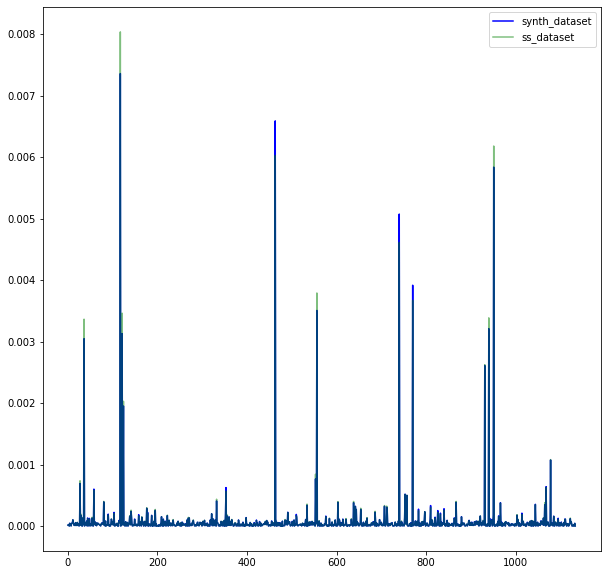

In [7]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
a = a.loc[~a.index.isin(names)]
b = b.loc[~b.index.isin(names)]
x = np.arange(a.shape[0])
ax1.plot(x, a['SRR7214450'].values.tolist(), color='b', label='synth_dataset')
ax1.plot(x, b[0].values, color='g', label='ss_dataset', alpha =.5)
plt.legend(loc='upper right')
plt.show()

In [8]:
from collections import Counter
def get_synth_dataset(unit_name, ss_dataset, names):
    edb = expressions.ExpressionBase()
    loaded_expressions = edb.load_expressions(unit_names = [unit_name], 
                                              units = 'runs', 
                                              space = 'genes', 
                                              measure = 'TPM', 
                                              subset = 'coding')
#     ss_dataset = ss_dataset.loc[df.index != 'MALAT1']
#      df.loc[df['column_name'] != some_value] 
#     ss_dataset = ss_dataset[ss_dataset.columns[(ss_dataset.columns!='MALAT1') & (ss_dataset.columns!='RPS27')]]
#     ss_dataset = ss_dataset.loc[:, ~ss_dataset.columns.isin(['MALAT1', 'RPS12', 'RPL13', 'RPS27', 'RPLP1'])]
    ss_dataset = ss_dataset.loc[:, ~ss_dataset.columns.isin(names)]
#     ss_dataset = ss_dataset[ss_dataset.columns[(ss_dataset.columns!='MALAT1')]]
#                                               & (ss_dataset.columns!='TPT1') & (ss_dataset.columns!='EEF1A1')]]
    all_genes = list(set(ss_dataset.columns.tolist()).intersection(set(loaded_expressions.index)))
    loaded_expressions = loaded_expressions.loc[all_genes]
    loaded_expressions['p'] = ((loaded_expressions[unit_name])/(loaded_expressions[unit_name].sum()))
    
    ss_dataset = ss_dataset.loc[:, all_genes]
    mu = ss_dataset.sum(axis = 1).mean()
    sigma = np.std(ss_dataset.sum(axis = 1))
    c = ss_dataset.sum(axis = 1).to_frame()
    names = c[(c[0]<=mu+2*sigma) & (c[0]>=mu-2*sigma)].index
    ss_dataset = ss_dataset.loc[names]
#     print(ss_dataset)
    table = pd.DataFrame(columns = all_genes)
    
    for i in range(ss_dataset.shape[0]):
#         n_transcripts = random.randint(minim, maxim + 1)
        n_transcripts = int(np.random.normal(loc = mu, scale = sigma))
#         print(n_transcripts)
        synth_reads = np.random.choice(loaded_expressions.index.tolist(), size=n_transcripts, replace=True, p=loaded_expressions['p'].values.tolist())
        sample = Counter(synth_reads)
        table = table.append(sample, ignore_index = True)
    table.fillna(0, inplace = True)    
    return ss_dataset, table    

In [9]:
ss_dataset, synth_dataset = get_synth_dataset('SRR7214450', ss_dataset, names)

In [10]:
print(ss_dataset.shape)
print(synth_dataset.shape)

(2101, 1134)
(2101, 1134)


## Сравнение синтетических и реальных single-cells

In [11]:
result = pd.concat([ss_dataset, synth_dataset])
# result = result.apply(lambda x: x*1000000/x.sum() , axis = 1)
# pd.isna(result)

In [12]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(result)
X_embedded.shape

(4202, 2)

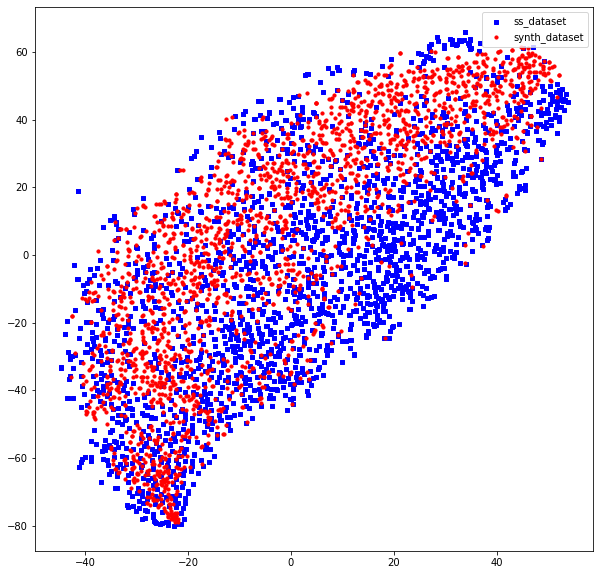

In [13]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(X_embedded[:int(X_embedded.shape[0]/2),0], X_embedded[:int(X_embedded.shape[0]/2),1], s=10, c='b', marker="s", label='ss_dataset')
ax1.scatter(X_embedded[int(X_embedded.shape[0]/2):,0], X_embedded[int(X_embedded.shape[0]/2):,1], s=10, c='r', marker="o", label='synth_dataset')
plt.legend(loc='upper right');
plt.show()

In [ ]:
##############################################################################################################################

In [87]:
unit_name = 'SRR7214450'
edb = expressions.ExpressionBase()
loaded_expressions = edb.load_expressions(unit_names = [unit_name], 
                                          units = 'runs', 
                                          space = 'genes', 
                                          measure = 'TPM', 
                                          subset = 'coding')
all_genes = list(set(ss_dataset.columns.tolist()).intersection(set(loaded_expressions.index)))
loaded_expressions = loaded_expressions.loc[all_genes]
# loaded_expressions['tpm'] = (loaded_expressions[unit_name]*1000000)/loaded_expression[unit_name].sum()
loaded_expressions['p'] = ((loaded_expressions[unit_name])/(loaded_expressions[unit_name].sum()))
loaded_expressions['examp'] = np.random.binomial(1, loaded_expressions['p'].values.tolist())
loaded_expressions['examp'].sum()

3

In [90]:
loaded_expressions[loaded_expressions['examp'] == 1].sum()

SRR7214450    23961.498121
p                 0.024023
examp             3.000000
dtype: float64

In [74]:
In [2]: np.random.binomial(1, [0.5, 0.5, 0.9, 0.02, 0.01])

array([1, 0, 1, 0, 0])

In [67]:
all_genes = list(set(ss_dataset.columns.tolist()).intersection(set(loaded_expressions.index)))
len(all_genes)

16320

In [70]:
a = get_synth_dataset('SRR7214450', ss_dataset)
a.fillna(0, inplace = True)
a = a.apply(lambda x: x*1000000/x.sum() , axis = 1)
a

MemoryError: Unable to allocate 155. MiB for an array with shape (16320, 1248) and data type float64

In [40]:
# ss_dataset = ss_dataset.loc[:, all_genes]
# ss_dataset = ss_dataset.apply(lambda x: x*1000000/x.sum() , axis = 1)
ss_dataset

CYB5R1     FAM178A        CIR1         FBL  \
GCGAGAATCGCTGTCT_10k_PBMC_v3    0.000000    0.000000    0.000000    0.000000   
CAACAGTAGCAAGGAA_10k_PBMC_v3    0.000000  108.401093    0.000000  325.203247   
TGTTCATGTGATAGAT_10k_PBMC_v3    0.000000    0.000000    0.000000   65.295464   
AGGACTTTCAAAGCCT_10k_PBMC_v3    0.000000    0.000000  109.134560  109.134560   
ATCACTTTCGGATTAC_10k_PBMC_v3  181.785141  363.570282    0.000000    0.000000   
...                                  ...         ...         ...         ...   
CCGGTGACACAGAGCA_10k_PBMC_v3    0.000000    0.000000    0.000000    0.000000   
AAACGAACACGACGTC_10k_PBMC_v3  131.440582    0.000000    0.000000  131.440582   
TAGGTTGTCTCAGGCG_10k_PBMC_v3  178.507675    0.000000    0.000000    0.000000   
GTTACCCCACAAAGTA_10k_PBMC_v3    0.000000    0.000000  119.645844    0.000000   
TCTACATAGGCACCAA_10k_PBMC_v3    0.000000    0.000000    0.000000    0.000000   

                              LRRC9      METTL5  C10orf128       MARK3  ETV7  \
GCGAGAATCGCTGTCT_10k_PBMC_v3    0.0  206.590225        0.0  103.295113   0.0   
CAACAGTAGCAAGGAA_10k_PBMC_v3    0.0  108.401093        0.0  108.401093   0.0   
TGTTCATGTGATAGAT_10k_PBMC_v3    0.0    0.000000        0.0    0.000000   0.0   
AGGACTTTCAAAGCCT_10k_PBMC_v3    0.0    0.000000        0.0    0.000000   0.0   
ATCACTTTCGGATTAC_10k_PBMC_v3    0.0    0.000000        0.0    0.000000   0.0   
...                             ...         ...        ...         ...   ...   
CCGGTGACACAGAGCA_10k_PBMC_v3    0.0  238.435883        0.0    0.000000   0.0   
AAACGAACACGACGTC_10k_PBMC_v3    0.0    0.000000        0.0    0.000000   0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3    0.0    0.000000        0.0  178.507675   0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3    0.0    0.000000        0.0  239.291687   0.0   
TCTACATAGGCACCAA_10k_PBMC_v3    0.0    0.000000        0.0  280.977814   0.0   

                                  PTGES3  ...        SPG7      SH2D6  SPESP1  \
GCGAGAATCGCTGTCT_10k_PBMC_v3  103.295113  ...  103.295113    0.00000     0.0   
CAACAGTAGCAAGGAA_10k_PBMC_v3    0.000000  ...  216.802185    0.00000     0.0   
TGTTCATGTGATAGAT_10k_PBMC_v3  261.181854  ...  130.590927    0.00000     0.0   
AGGACTTTCAAAGCCT_10k_PBMC_v3  163.701843  ...   54.567280  109.13456     0.0   
ATCACTTTCGGATTAC_10k_PBMC_v3  181.785141  ...  181.785141    0.00000     0.0   
...                                  ...  ...         ...        ...     ...   
CCGGTGACACAGAGCA_10k_PBMC_v3  119.217941  ...  119.217941    0.00000     0.0   
AAACGAACACGACGTC_10k_PBMC_v3  394.321747  ...  394.321747    0.00000     0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3  357.015350  ...  178.507675    0.00000     0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3  119.645844  ...  239.291687    0.00000     0.0   
TCTACATAGGCACCAA_10k_PBMC_v3  140.488907  ...  140.488907    0.00000     0.0   

                                  SH3BP1  CHRNE         DR1  LURAP1  \
GCGAGAATCGCTGTCT_10k_PBMC_v3    0.000000    0.0  206.590225     0.0   
CAACAGTAGCAAGGAA_10k_PBMC_v3    0.000000    0.0    0.000000     0.0   
TGTTCATGTGATAGAT_10k_PBMC_v3    0.000000    0.0    0.000000     0.0   
AGGACTTTCAAAGCCT_10k_PBMC_v3  163.701843    0.0    0.000000     0.0   
ATCACTTTCGGATTAC_10k_PBMC_v3    0.000000    0.0    0.000000     0.0   
...                                  ...    ...         ...     ...   
CCGGTGACACAGAGCA_10k_PBMC_v3  119.217941    0.0  238.435883     0.0   
AAACGAACACGACGTC_10k_PBMC_v3    0.000000    0.0    0.000000     0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3    0.000000    0.0    0.000000     0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3  119.645844    0.0    0.000000     0.0   
TCTACATAGGCACCAA_10k_PBMC_v3  140.488907    0.0  140.488907     0.0   

                                   SYNRG        OGDH     TMEM261  
GCGAGAATCGCTGTCT_10k_PBMC_v3  103.295113    0.000000  103.295113  
CAACAGTAGCAAGGAA_10k_PBMC_v3    0.000000    0.000000  216.802185  
TGTTCATGTGATAGAT_10k_PBMC_v3    0.000000    0.000000    0.000000  
AGGACTTTCAAAGCCT_10k_PBMC_v3  

In [65]:
# result = pd.concat([a, ss_dataset])
result

CYB5R1  FAM178A        CIR1         FBL  \
0                               0.000000      0.0    0.000000    0.000000   
1                               0.000000      0.0    0.000000  253.847257   
2                               0.000000      0.0    0.000000    0.000000   
3                               0.000000      0.0    0.000000    0.000000   
4                               0.000000      0.0    0.000000  255.928280   
...                                  ...      ...         ...         ...   
CCGGTGACACAGAGCA_10k_PBMC_v3    0.000000      0.0    0.000000    0.000000   
AAACGAACACGACGTC_10k_PBMC_v3  131.440582      0.0    0.000000  131.440582   
TAGGTTGTCTCAGGCG_10k_PBMC_v3  178.507675      0.0    0.000000    0.000000   
GTTACCCCACAAAGTA_10k_PBMC_v3    0.000000      0.0  119.645844    0.000000   
TCTACATAGGCACCAA_10k_PBMC_v3    0.000000      0.0    0.000000    0.000000   

                              LRRC9      METTL5  C10orf128       MARK3  ETV7  \
0                               0.0    0.000000        0.0    0.000000   0.0   
1                               0.0    0.000000        0.0    0.000000   0.0   
2                               0.0    0.000000        0.0  123.398296   0.0   
3                               0.0    0.000000        0.0    0.000000   0.0   
4                               0.0    0.000000        0.0  122.327723   0.0   
...                             ...         ...        ...         ...   ...   
CCGGTGACACAGAGCA_10k_PBMC_v3    0.0  238.435883        0.0    0.000000   0.0   
AAACGAACACGACGTC_10k_PBMC_v3    0.0    0.000000        0.0    0.000000   0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3    0.0    0.000000        0.0  178.507675   0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3    0.0    0.000000        0.0  239.291687   0.0   
TCTACATAGGCACCAA_10k_PBMC_v3    0.0    0.000000        0.0  280.977814   0.0   

                                  PTGES3  ...        SPG7  SH2D6  SPESP1  \
0                               0.000000  ...    0.000000    0.0     0.0   
1                             364.291503  ...    0.000000    0.0     0.0   
2                               0.000000  ...    0.000000    0.0     0.0   
3                               0.000000  ...    0.000000    0.0     0.0   
4                               0.000000  ...   55.749734    0.0     0.0   
...                                  ...  ...         ...    ...     ...   
CCGGTGACACAGAGCA_10k_PBMC_v3  119.217941  ...  119.217941    0.0     0.0   
AAACGAACACGACGTC_10k_PBMC_v3  394.321747  ...  394.321747    0.0     0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3  357.015350  ...  178.507675    0.0     0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3  119.645844  ...  239.291687    0.0     0.0   
TCTACATAGGCACCAA_10k_PBMC_v3  140.488907  ...  140.488907    0.0     0.0   

                                  SH3BP1  CHRNE         DR1  LURAP1  \
0                               0.000000    0.0    0.000000     0.0   
1                              13.372059    0.0  136.898839     0.0   
2                               0.000000    0.0    0.000000     0.0   
3                               0.000000    0.0    0.000000     0.0   
4                               0.000000    0.0  138.021127     0.0   
...                                  ...    ...         ...     ...   
CCGGTGACACAGAGCA_10k_PBMC_v3  119.217941    0.0  238.435883     0.0   
AAACGAACACGACGTC_10k_PBMC_v3    0.000000    0.0    0.000000     0.0   
TAGGTTGTCTCAGGCG_10k_PBMC_v3    0.000000    0.0    0.000000     0.0   
GTTACCCCACAAAGTA_10k_PBMC_v3  119.645844    0.0    0.000000     0.0   
TCTACATAGGCACCAA_10k_PBMC_v3  140.488907    0.0  140.488907     0.0   

                                   SYNRG        OGDH     TMEM261  
0                               0.000000    0.000000    0.000000  
1                               0.000000   64.305041    0.000000  
2                               0.000000    0.000000    0.000000  
3                               0.000000    0.000000    0.000000  
4                               0.000000   64.8

In [51]:
# >>> import numpy as np
from sklearn.manifold import TSNE
# >>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(result)
X_embedded.shape

(4366, 2)

In [52]:
X_embedded

array([[ 14.214795,  18.46563 ],
       [ 40.08401 ,  21.054129],
       [ 30.513758,   1.264613],
       ...,
       [-27.1826  , -29.479313],
       [-40.773605,  -9.506855],
       [-24.7763  , -22.44418 ]], dtype=float32)

2183.0
4366


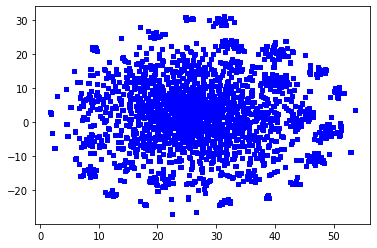

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
i = (X_embedded.shape[0]/2)
print(i)
ax1.scatter(X_embedded[:int(X_embedded.shape[0]/2),0], X_embedded[:int(X_embedded.shape[0]/2),1], s=10, c='b', marker="s", label='ss_dataset')
# ax1.scatter(synth_index,y = synth_dataset['tpm'].values.tolist(), s=10, c='r', marker="o", label='synth_dataset')
# plt.legend(loc='upper right');
print(len(X_embedded[:X_embedded.shape[0],0]))
plt.show()

/home/vlineva/vlin/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

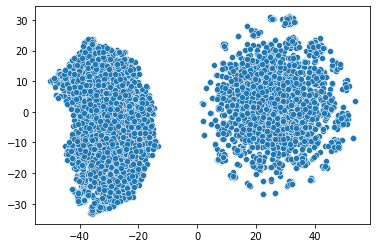

In [53]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)

In [27]:
edb = expressions.ExpressionBase()
loaded_expressions = edb.load_expressions(unit_names = ['SRR7214450'], 
                                          units = 'runs', 
                                          space = 'genes', 
                                          measure = 'TPM', 
                                          subset = 'coding')
loaded_expressions

SRR7214450
Gene               
A1BG       0.121391
A1CF       0.196323
A2M        4.858171
A2ML1      0.659242
A3GALT2    0.232624
...             ...
ZYG11B    31.324212
ZYX       26.949340
ZZEF1     37.859375
ZZZ3      76.966867
pk         0.663236

[20062 rows x 1 columns]

In [28]:
all_genes = list(set(ss_dataset.columns.tolist()).intersection(set(loaded_expressions.index)))
len(all_genes)

16320

In [21]:
#for CD4_T_cells
synth_dataset = get_synth_dataset('SRR7214450', ss_dataset)
# #for CD8_T_cells
# synth_dataset = get_synth_dataset('SRR4448906', ss_dataset)
synth_dataset

initial_tpm          tpm
Gene                             
SRPK1      38.146422    49.325045
RPL23A   5171.381863  6686.829994
PGD        41.119136    53.168898
RPL27    3780.472230  4888.321105
RPS23    3325.219071  4299.658237
...              ...          ...
ADPGK      22.275920    28.803769
NAP1L4    241.863793   312.740793
STXBP3     74.597820    96.458346
DENND4B    27.884417    36.055809
FAM111A    50.144937    64.839665

[3048 rows x 2 columns]

In [27]:
# CD4_T_cells: SRR7214450
# CD8_T_cells: SRR4448906
def plot_hist(unit_name):
    edb = expressions.ExpressionBase()
    loaded_expressions = edb.load_expressions(unit_names = [unit_name], 
                                              units = 'runs', 
                                              space = 'genes', 
                                              measure = 'TPM', 
                                              subset = 'coding')
    a = loaded_expressions[loaded_expressions[unit_name]!= 0][unit_name]
    for i in range(4):
        plt.hist(a.values.tolist(), bins = 50,
                range = (i*5000, 5000*(i+1)))
        plt.show()

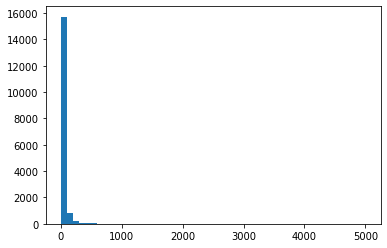

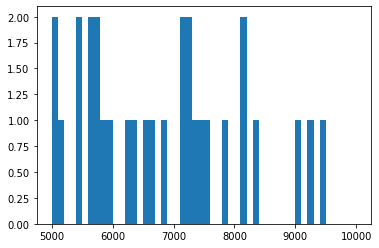

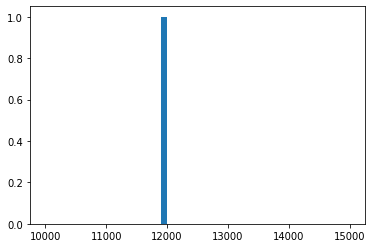

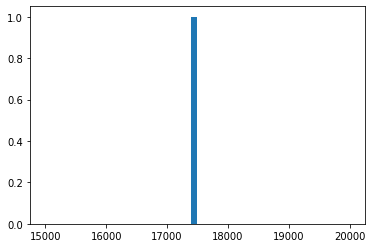

In [28]:
plot_hist('SRR7214450')

In [9]:
# import numpy as np
# loaded_expressions['sample'] = np.random.binomial(1, loaded_expressions['p'].values.tolist())

In [10]:
# loaded_expressions[loaded_expressions['sample'] == 1]

## Сравнение синтетических и реальных single-cells

In [44]:
# import seaborn as sns
# import bioreactor
# from bioreactor.plotting import umap_plot

In [45]:
# plt.scatter(np.arange(synth_dataset.shape[0]), sorted(synth_dataset['tpm'].values.tolist(), reverse = True))

In [46]:
# plt.scatter(np.arange(ss_dataset.shape[0]), sorted(ss_dataset['tpm'].values.tolist(), reverse = True))

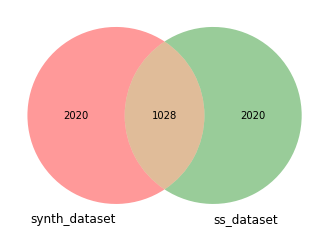

In [47]:
from matplotlib_venn import venn2, venn2_circles
venn2([set(synth_dataset.index), set(ss_dataset.index)], ('synth_dataset', 'ss_dataset'))
plt.show()

In [48]:
all_genes = set(synth_dataset.index.tolist() + ss_dataset.index.tolist())
all_genes = list(all_genes)

In [49]:
synth_index = []
for gene in synth_dataset.index:
    if gene in all_genes:
        synth_index.append(all_genes.index(gene))

In [50]:
ss_index = []
for gene in ss_dataset.index:
    if gene in all_genes:
        ss_index.append(all_genes.index(gene))

In [51]:
ss_dataset

initial_umi           tpm
PCNP                1.0     90.025207
RPL13             132.0  11883.327332
OTUD6B-AS1          2.0    180.050414
ATP6V0E1            2.0    180.050414
AMFR                2.0    180.050414
...                 ...           ...
RPL4               25.0   2250.630176
G3BP2               2.0    180.050414
SP4                 1.0     90.025207
ZNF221              1.0     90.025207
SNAP23              1.0     90.025207

[3048 rows x 2 columns]

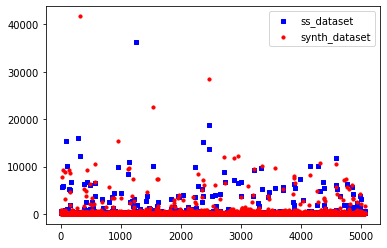

In [52]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(ss_index, y = ss_dataset['tpm'].values.tolist(), s=10, c='b', marker="s", label='ss_dataset')
ax1.scatter(synth_index,y = synth_dataset['tpm'].values.tolist(), s=10, c='r', marker="o", label='synth_dataset')
plt.legend(loc='upper right');
plt.show()